In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split


In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pims_nd2
import nd2
import json
from PIL import Image

In [12]:
# Function to load frames from a stack directory (you may need to adjust this)
def get_frames_from_directory(stack_dir):
    frames = []
    frames_dir = os.path.join(stack_dir, "frames") # we need this subfolder, where individual frames within a stack are found
    for root, _, files in os.walk(frames_dir):
        for file in files:
            if file.endswith(".png"):  # Adjust the file format as needed
                frame_path = os.path.join(root, file)
                frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)
                frames.append(frame)
    return frames

In [13]:
def calculate_sharpness_score(frame):
    try:
        if isinstance(frame, np.ndarray):
            # Convert to 16-bit unsigned integer if not already
            if frame.dtype != np.uint16:
                frame = frame.astype(np.uint16)

            # Calculate sharpness score using Laplacian method
            sharpness_score = cv2.Laplacian(frame, cv2.CV_64F).var()
            return sharpness_score

        elif isinstance(frame, Image.Image):
            # Convert to NumPy array
            frame = np.array(frame, dtype=np.uint16)

            # Calculate sharpness score using Laplacian method
            sharpness_score = cv2.Laplacian(frame, cv2.CV_64F).var()
            return sharpness_score
        else:
            return None  # Return None for unsupported frame type

    except Exception as e:
        print(f"Error calculating sharpness score: {str(e)}")
        return None  # Return None to indicate that there was an error processing the frame


In [26]:
def analyze_stack(stack_path):
    print("==================================")
    print(f"Analyzing Stack: {stack_path}...")

    # Load frames from the stack directory (you may need to adjust this part)
    stack_frames = get_frames_from_directory(stack_path)

    if not stack_frames:
        print(f"No frames found in Stack at {stack_path}.")
        return

    # Initialize a list to store sharpness scores for each frame
    sharpness_scores = []

    # Calculate the optimal frame index (middle frame)
    optimal_frame = (1 + len(stack_frames)) // 2

    for frame_index, frame in enumerate(stack_frames):
        score = calculate_sharpness_score(frame)

        if score is not None:
            sharpness_scores.append(score)
            print(f"Frame {frame_index}: Sharpness Score = {score}")

        if frame_index == optimal_frame:
            print(f"Frame {frame_index}: Optimal Focus Frame, Sharpness Score = {score}")

    # Create a directory to save analysis results
    analysis_dir = os.path.join(stack_path, "analysis")
    os.makedirs(analysis_dir, exist_ok=True)

    if sharpness_scores:
        # Calculate the overall sharpness score for the stack (e.g., mean or median)
        overall_sharpness = np.mean(sharpness_scores)
        median_sharpness = np.median(sharpness_scores)

        print(f"Overall Sharpness Score (Mean) for Stack: {overall_sharpness}")
        print(f"Overall Sharpness Score (Median) for Stack: {median_sharpness}")

        # Create a box plot for the Sharpness scores of this stack and save it under the analysis folder
        plt.figure(figsize=(8, 6))
        plt.boxplot(sharpness_scores)
        plt.title("Sharpness Score Variation for Stack")
        plt.ylabel("Sharpness Score")
        plt.savefig(os.path.join(analysis_dir, "fsharpnessscore_variation.png"))

        # Create a histogram for the Sharpness scores of this stack and save it under the analysis folder
        plt.figure(figsize=(8, 6))
        plt.hist(sharpness_scores, bins=10, edgecolor='black')
        plt.title("Sharpness Score Histogram for Stack")
        plt.xlabel("Sharpness Score")
        plt.ylabel("Frequency")
        plt.savefig(os.path.join(analysis_dir, "sharpness_score_histogram.png"))

    else:
        print("No frames with valid sharpness scores in Stack.")

    print("Analysis completed for Stack.")
     # Preprocess frames for PyTorch model
    tensor_frames = [torch.tensor(frame, dtype=torch.float32).unsqueeze(0) for frame in stack_frames]
    tensor_frames = torch.stack(tensor_frames)
    # Generate dummy Z-coordinate labels for now (replace this later with actual labels if available)
    labels = torch.tensor(list(range(len(stack_frames))), dtype=torch.float32)

In [27]:
# load the nd2 files and begin the analysis
def load_data(nd2filepath):
    file_name_without_extension = nd2filepath[:-4]
    experiment_dir = file_name_without_extension
    stacks_dir = file_name_without_extension + "/stacks"

    # Create directories if they don't exist
    print("=========================================")
    print("Creating folders for the stacks and metadata...")
    os.makedirs(stacks_dir, exist_ok=True)

    # Save the metadata of the ND2 file itself
    with pims_nd2.ND2_Reader(nd2filepath) as ndfile:
        metadata_dict = ndfile.metadata
        json.dump(metadata_dict, open(experiment_dir + "/experiment_metadata.json", 'w'), default=str)

    # Get dimensions and frame count
    with nd2.ND2File(nd2filepath) as ndfile:
        dimension1 = 1
        dimension2 = 1
        try:
            dimension1 = ndfile.shape[-4]
            dimension2 = ndfile.shape[-5]
        except:
            pass

        tiff_frame_count = ndfile.shape[-3]

        print("--- Data:", file_name_without_extension)
        print("--- #Stacks:", dimension1 * dimension2)
        print("--- #Frames per Stack:", tiff_frame_count)  
        # get the perfectly focused frame
        print("--- Optimal Focus Frame Index",  (1 + tiff_frame_count) // 2 )# Calculate the middle frame index

        image_arrays = ndfile.asarray().reshape((dimension1 * dimension2 * tiff_frame_count, ndfile.shape[-2], ndfile.shape[-1]))

        # one nd2 file is made of multiple stacks
        # one stack is made of multiple frames
        for tiff_stack_counter in range(dimension1 * dimension2):
            stack_images = []
            print("=========Stack#:" + str(tiff_stack_counter))
            # create a dir for the individual stack
            stack_dir = os.path.join(stacks_dir, f"stack_{tiff_stack_counter}")
            os.makedirs(stack_dir, exist_ok=True)
            # loop for the frames within the stack
            for frame_index in range(tiff_frame_count):
                # create the necessary folder for frames
                os.makedirs(stack_dir + "/frames", exist_ok=True)
                image_array = image_arrays[tiff_stack_counter * tiff_frame_count + frame_index]
                image_array = image_array.astype(np.uint16)
                image = Image.fromarray(image_array, 'I;16')
                stack_images.append(image)
                # Save the frame under the /frames subdirectory
                frame = os.path.join(stack_dir, "frames", f"frame_{frame_index}.png")
                image.save(frame, format="png")

            str_tiff_stack_counter = str(tiff_stack_counter % dimension2)
            stack_key = "i" + (10 - len(str_tiff_stack_counter)) * "0" + str_tiff_stack_counter
            positions_metadata = ndfile.unstructured_metadata()["ImageMetadataLV"]['SLxExperiment']["ppNextLevelEx"]["i0000000000"]["uLoopPars"]["Points"][stack_key]
            print("=Metadata:" , positions_metadata)
            json.dump(positions_metadata, open(stack_dir + "/stack_" + str(tiff_stack_counter) + "_metadata.json", 'w'))
            image1 = stack_images[0]
            image1.save(stack_dir + "/stack_" + str(tiff_stack_counter) + ".tiff", format="tiff", append_images=stack_images[1:], save_all=True, duration=500, loop=0)

    # return the path of the created analysis folder
    return stacks_dir

In [36]:
stack_dir = load_data("./zstackexperiment_29082023.nd2")
stack_dir

Creating folders for the stacks and metadata...
--- Data: ./zstackexperiment_29082023
--- #Stacks: 1700
--- #Frames per Stack: 9
--- Optimal Focus Frame Index 5


c:\Users\m1000\anaconda3\envs\tensorflow\lib\site-packages\pims\base_frames.py:478: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"


=========Stack#:0
=Metadata: {'dPFSOffset': 7427.0, 'dPosX': 6359.1, 'dPosY': -4497.8, 'dPosZ': 2959.7250000000004, 'dPosName': ''}
=========Stack#:1
=Metadata: {'dPFSOffset': 7469.0, 'dPosX': 6136.5, 'dPosY': -4497.900000000001, 'dPosZ': 2959.5750000000003, 'dPosName': ''}
=========Stack#:2
=Metadata: {'dPFSOffset': 7469.0, 'dPosX': 6018.3, 'dPosY': -4497.900000000001, 'dPosZ': 2959.425, 'dPosName': ''}
=========Stack#:3
=Metadata: {'dPFSOffset': 7469.0, 'dPosX': 5911.700000000001, 'dPosY': -4497.900000000001, 'dPosZ': 2959.4, 'dPosName': ''}
=========Stack#:4
=Metadata: {'dPFSOffset': 7412.0, 'dPosX': 5801.5, 'dPosY': -4497.900000000001, 'dPosZ': 2959.3, 'dPosName': ''}
=========Stack#:5
=Metadata: {'dPFSOffset': 7576.0, 'dPosX': 5694.3, 'dPosY': -4497.900000000001, 'dPosZ': 2959.4, 'dPosName': ''}
=========Stack#:6
=Metadata: {'dPFSOffset': 7384.0, 'dPosX': 5582.400000000001, 'dPosY': -4497.900000000001, 'dPosZ': 2959.125, 'dPosName': ''}
=========Stack#:7
=Metadata: {'dPFSOffset': 

'./zstackexperiment_29082023/stacks'

In [34]:
def analyze_stacks(stacks_dir):
    # Get a sorted list of subdirectories
    stack_dirs = sorted([d for d in os.listdir(stacks_dir) if os.path.isdir(os.path.join(stacks_dir, d))])

    # Iterate through the stack directories
    for stack_dir in stack_dirs:
        stack_path = os.path.join(stacks_dir, stack_dir)
        analyze_stack(stack_path)

Analyzing Stack: ./zstack_once_with_full_chambers/stacks\stack_0...
Frame 0: Sharpness Score = 3.98229957272775
Frame 1: Sharpness Score = 3.9909452165371357
Frame 2: Sharpness Score = 5.334195196964065
Frame 3: Sharpness Score = 5.812309132086567
Frame 4: Sharpness Score = 6.3172521785947495
Frame 5: Sharpness Score = 6.980824447504066
Frame 6: Sharpness Score = 7.62952576969274
Frame 7: Sharpness Score = 8.049066032833238
Frame 8: Sharpness Score = 8.247076666732141
Frame 9: Sharpness Score = 8.198499570951379
Frame 10: Sharpness Score = 7.942340763026263
Frame 11: Sharpness Score = 7.244473783865948
Frame 12: Sharpness Score = 4.0457943011266275
Frame 13: Sharpness Score = 6.648833897246663
Frame 14: Sharpness Score = 6.483545809022662
Frame 15: Sharpness Score = 6.32175029362508
Frame 16: Sharpness Score = 6.018006558404968
Frame 17: Sharpness Score = 6.073084988964141
Frame 18: Sharpness Score = 6.107070430336943
Frame 19: Sharpness Score = 6.074353211792729
Frame 20: Sharpness Sc

C:\Users\m1000\AppData\Local\Temp\ipykernel_4232\757767459.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


Analysis completed for Stack.
Analyzing Stack: ./zstack_once_with_full_chambers/stacks\stack_9...
Frame 0: Sharpness Score = 3.6883922011353416
Frame 1: Sharpness Score = 3.7221178806896553
Frame 2: Sharpness Score = 4.065171605516417
Frame 3: Sharpness Score = 4.149190173155673
Frame 4: Sharpness Score = 4.224101727120537
Frame 5: Sharpness Score = 4.338519111530611
Frame 6: Sharpness Score = 4.434617718840402
Frame 7: Sharpness Score = 4.56691786964482
Frame 8: Sharpness Score = 4.716879118536667
Frame 9: Sharpness Score = 4.97306261919892
Frame 10: Sharpness Score = 5.261162338261906
Frame 11: Sharpness Score = 5.626002555268343
Frame 12: Sharpness Score = 3.7389339030668225
Frame 13: Sharpness Score = 5.978931474656229
Frame 14: Sharpness Score = 6.349129227445946
Frame 15: Sharpness Score = 6.650604640333771
Frame 16: Sharpness Score = 6.887153689928094
Frame 17: Sharpness Score = 6.960824972353706
Frame 18: Sharpness Score = 6.927839833559607
Frame 19: Sharpness Score = 6.8860792

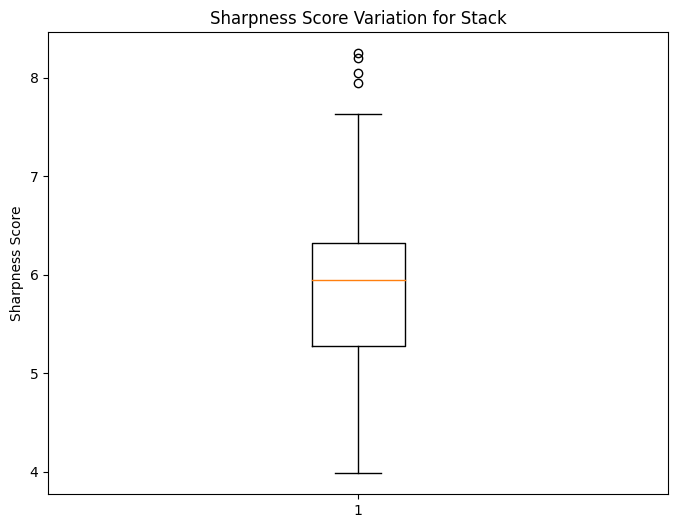

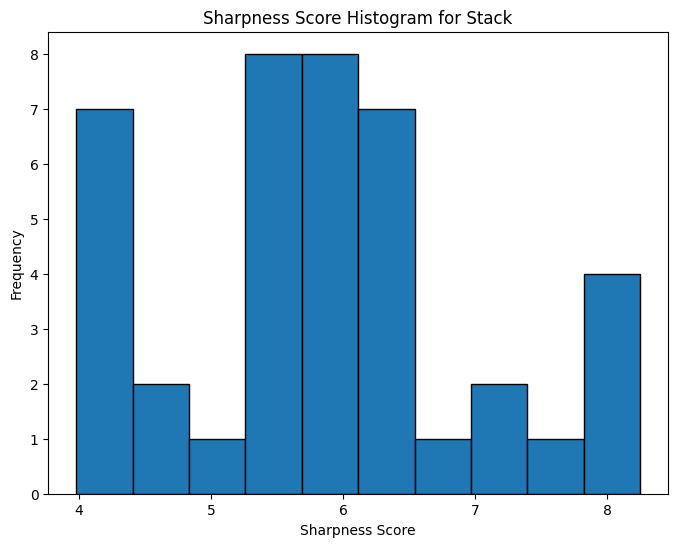

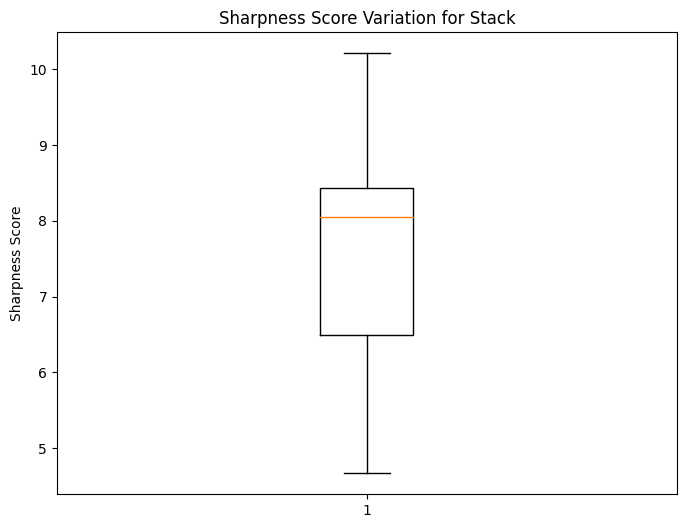

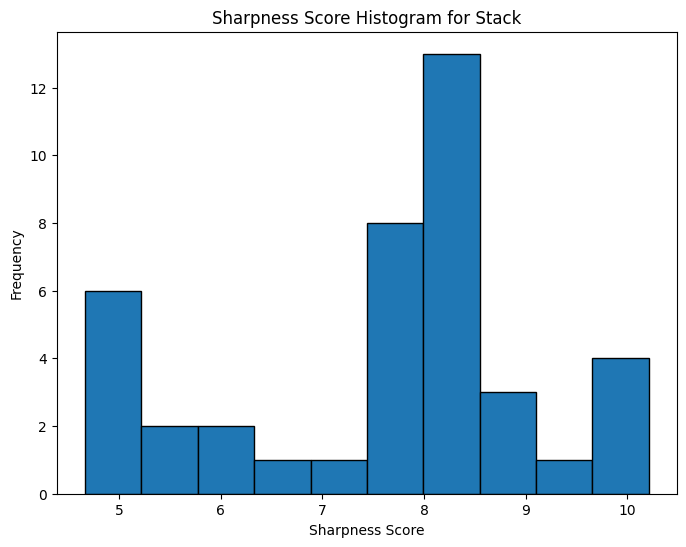

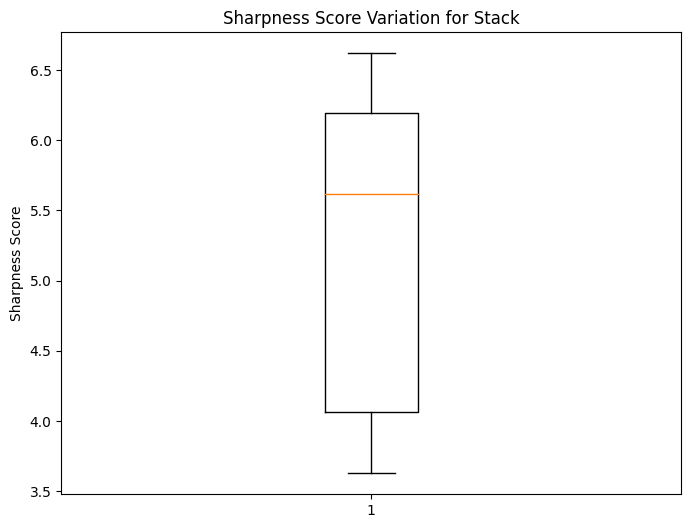

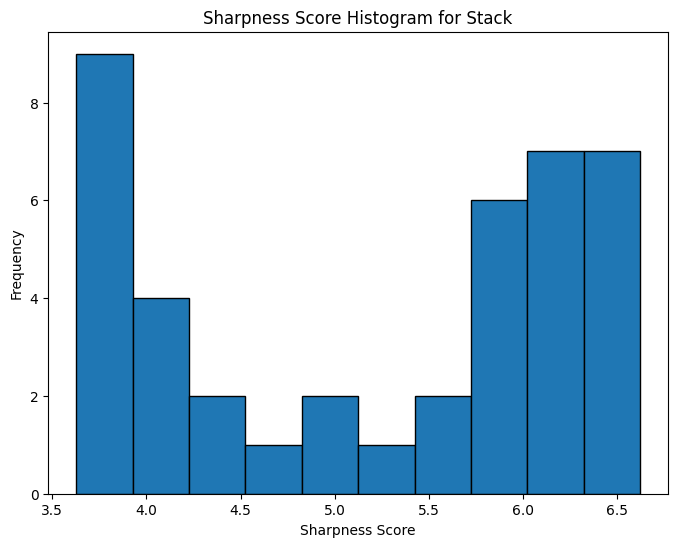

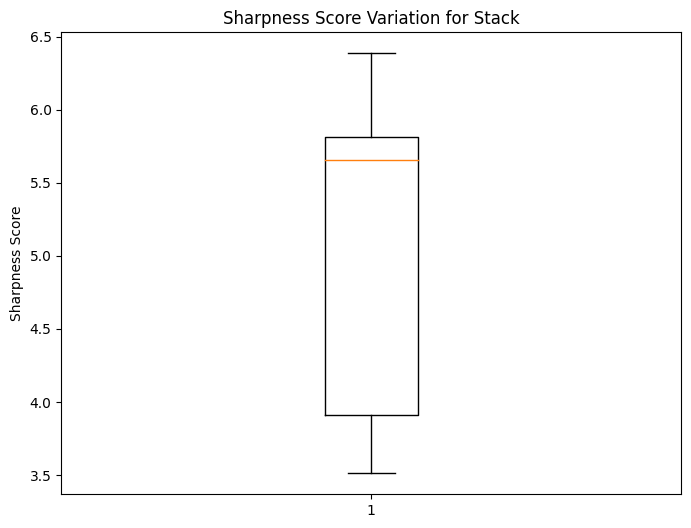

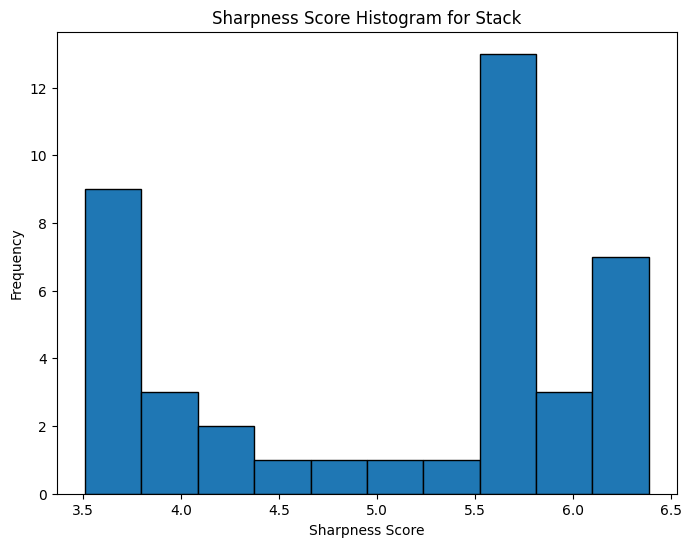

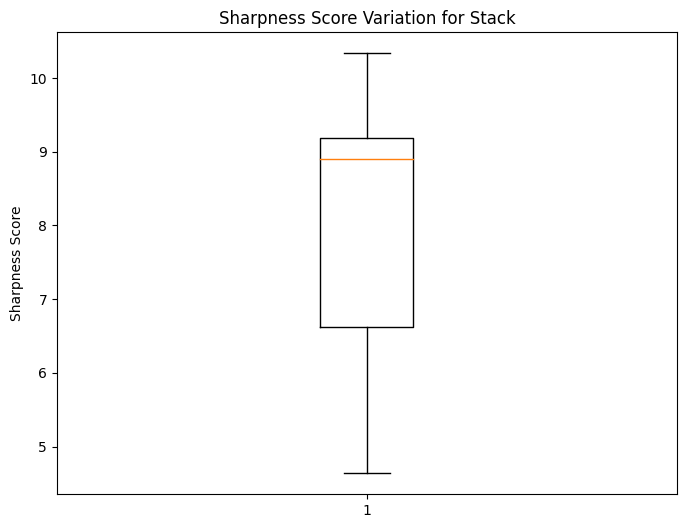

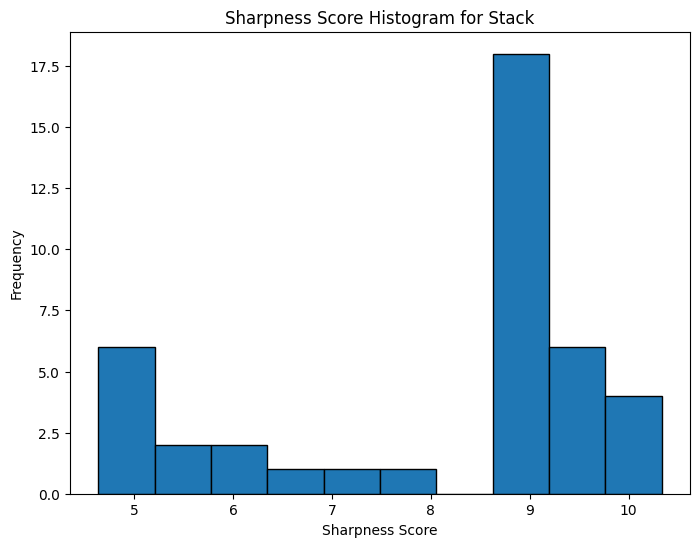

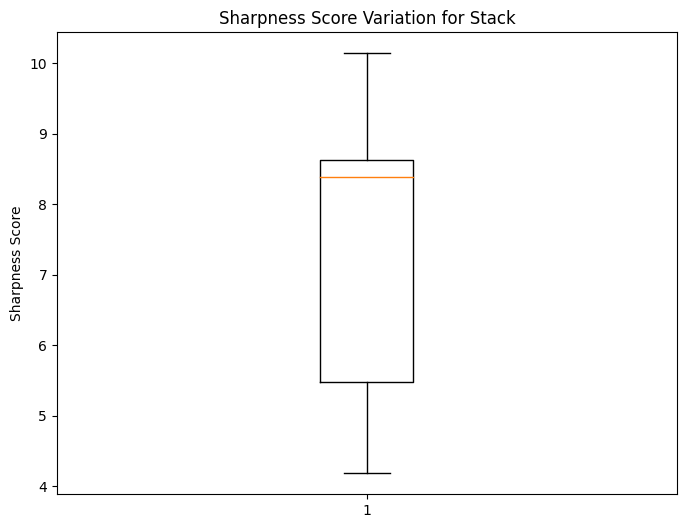

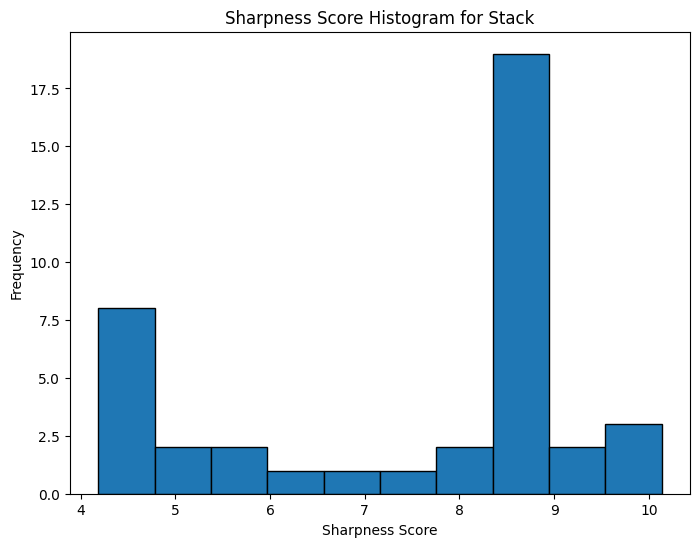

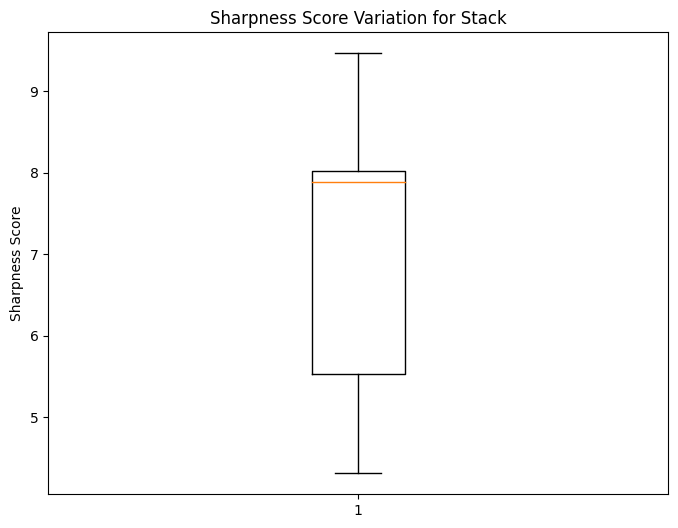

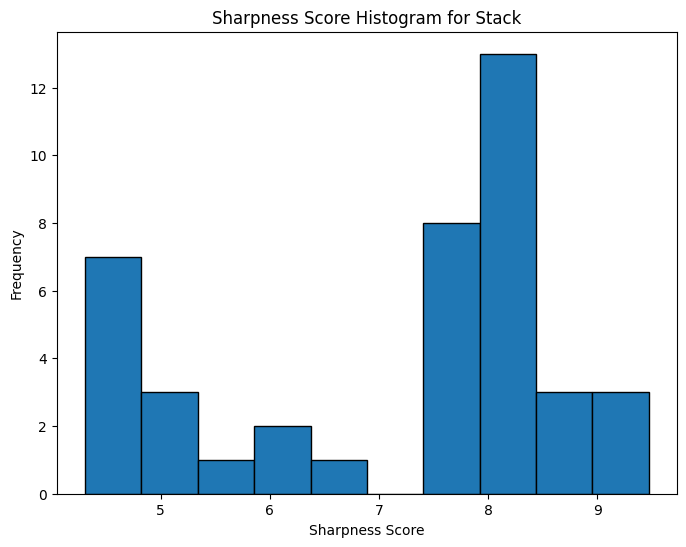

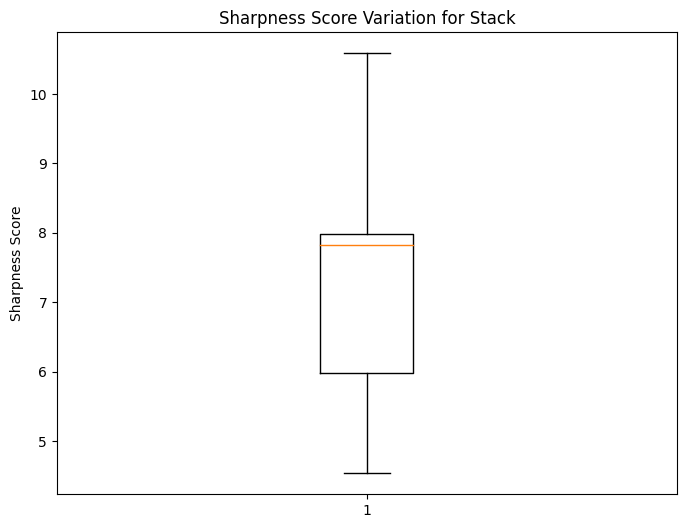

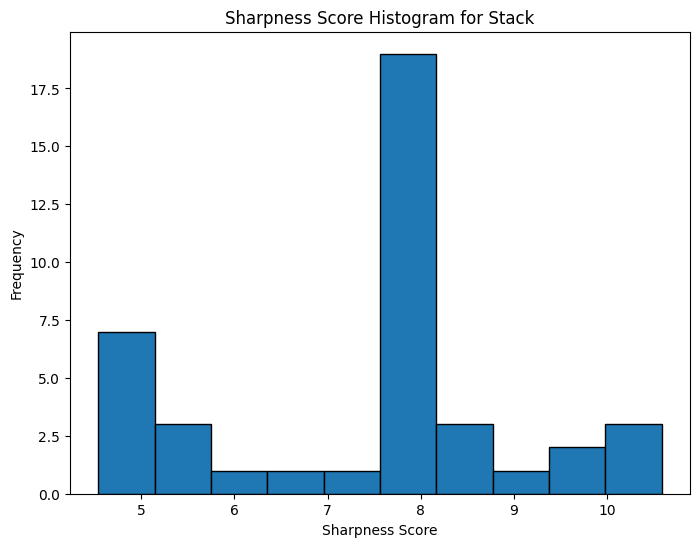

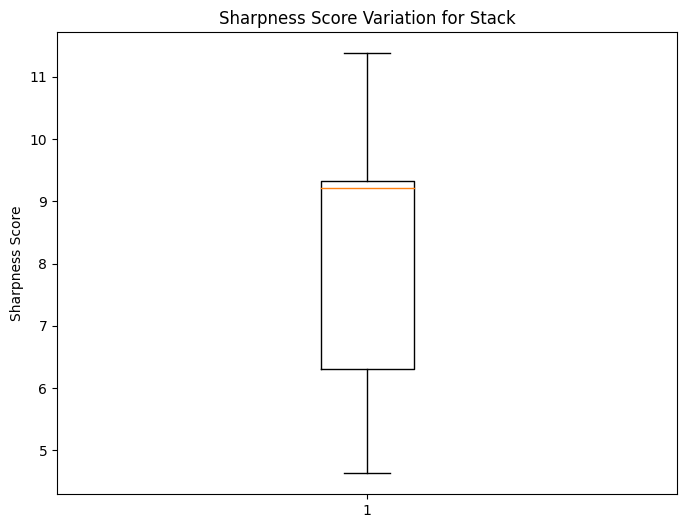

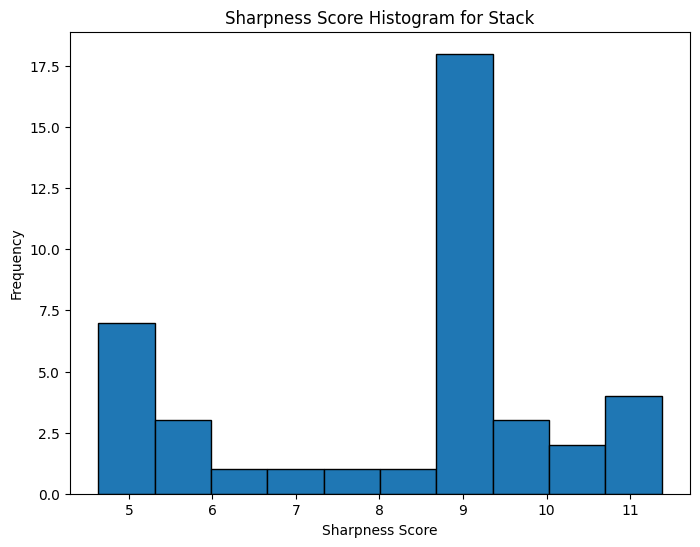

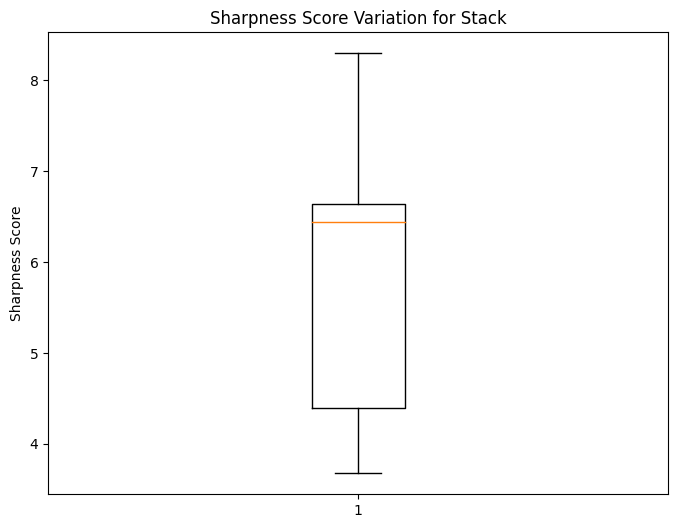

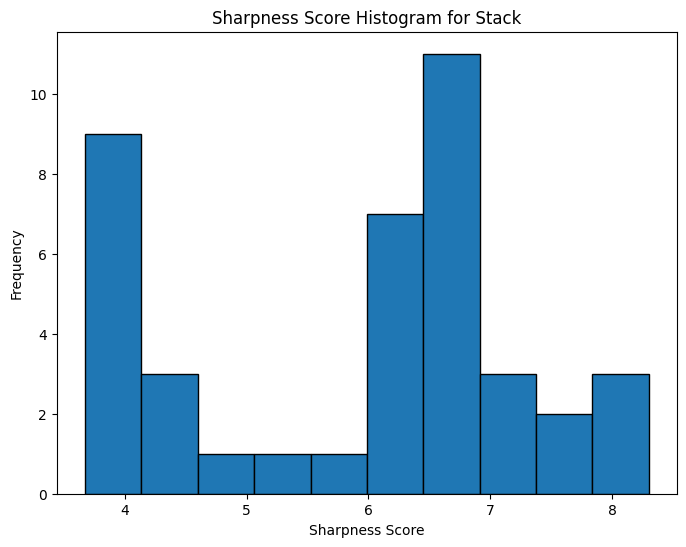

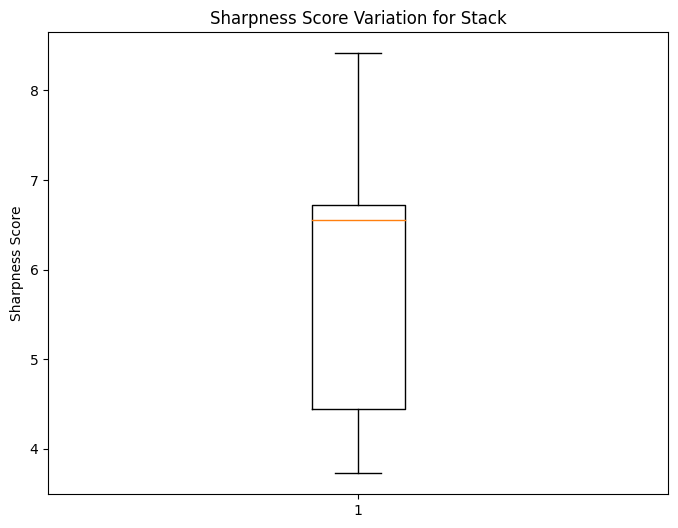

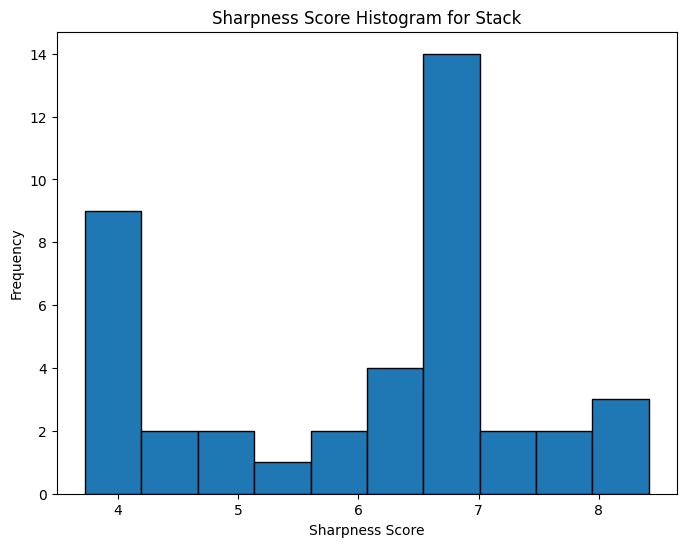

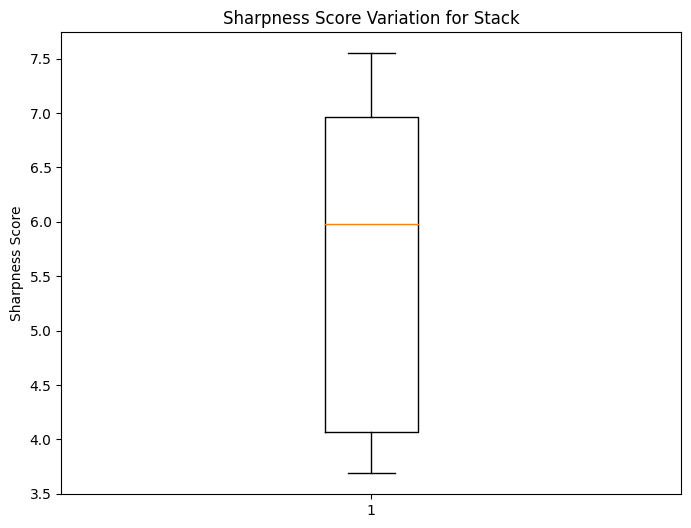

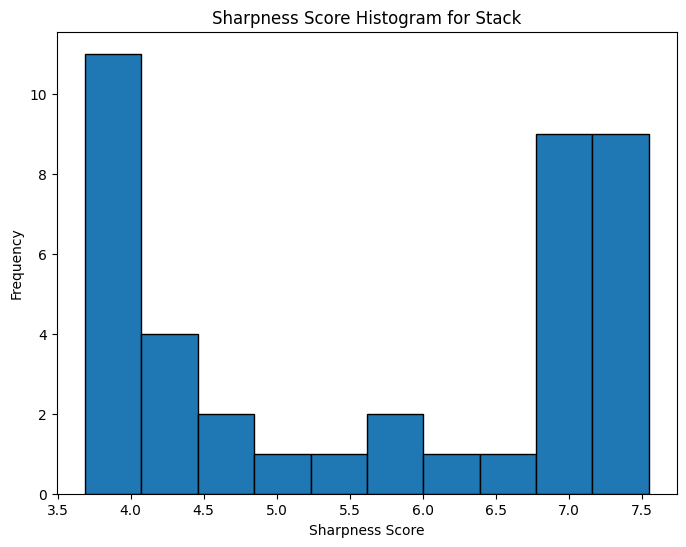

In [35]:
analyze_stacks(stack_dir)

In [45]:
import os
import json
import pandas as pd

def calculate_z_coordinates(base_folder):
    # Base folder for the stacks
    stacks_folder = os.path.join(base_folder, "stacks")

    # List to collect data rows
    data_rows = []

    # List all stack folders
    stack_folders = [d for d in os.listdir(stacks_folder) if os.path.isdir(os.path.join(stacks_folder, d))]
    for stack_folder in sorted(stack_folders):
        # Path to the current stack
        stack_path = os.path.join(stacks_folder, stack_folder)

        # Read metadata for the current stack
        with open(os.path.join(stack_path, f"{stack_folder}_metadata.json"), 'r') as f:
            metadata = json.load(f)

        # Get the Z-coordinate of the optimal frame from metadata
        z_optimal = metadata['dPosZ']

        # Calculate Z-coordinate for each frame in the stack
        for frame_index in range(9):  # As there are 9 frames for each stack
            z_frame = z_optimal + (frame_index - 4)  # Subtracting 4 as frame_4.png is the optimal focus frame
            data_rows.append({
                'Stack_Number': stack_folder.split("_")[1],
                'Frame_Index': frame_index,
                'Z_Coordinate': z_frame
            })

    # Create a DataFrame from the data rows
    df = pd.DataFrame(data_rows)

    # Save DataFrame to a CSV file
    df.to_csv(os.path.join(base_folder, 'z_coordinates.csv'), index=False)

    return df

# Usage example
base_folder = "zstackexperiment_29082023"
df = calculate_z_coordinates(base_folder)


In [47]:
# Convert 'Stack_Number' to integer type
df['Stack_Number'] = df['Stack_Number'].astype(int)

# Sort by 'Stack_Number' in ascending order
df = df.sort_values(by='Stack_Number').reset_index(drop=True)

# Display the first 20 rows
df.head(20)


,Stack_Number,Frame_Index,Z_Coordinate
0,0,0,2955.725
1,0,1,2956.725
2,0,2,2957.725
3,0,3,2958.725
4,0,4,2959.725
5,0,5,2960.725
6,0,6,2961.725
7,0,7,2962.725
8,0,8,2963.725
9,1,7,2962.575


In [146]:
df.to_csv("data.csv", index=False)

In [50]:
import shutil
from tqdm import tqdm

# Create the "images" directory if it doesn't exist
images_folder = os.path.join("images")
os.makedirs(images_folder, exist_ok=True)

# Iterate over the DataFrame rows with tqdm for progress
for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Moving images"):
    # Construct the original image path
    original_image_path = os.path.join(base_folder, "stacks", f"stack_{int(row['Stack_Number'])}", "frames", f"frame_{int(row['Frame_Index'])}.png")
    
    # Construct the new image path
    new_image_path = os.path.join(images_folder, f"{index}.png")
    
    # Move and rename the image
    shutil.move(original_image_path, new_image_path)


Moving images: 100%|██████████| 15300/15300 [00:10<00:00, 1418.39it/s]


In [56]:
df.shape

(15300, 3)

In [1]:
import pandas as pd
df = pd.read_csv("data.csv")
df.head()

,Stack_Number,Frame_Index,Z_Coordinate
0,0,0,2955.725
1,0,1,2956.725
2,0,2,2957.725
3,0,3,2958.725
4,0,4,2959.725


In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import random_split
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pims_nd2
import nd2
import json
from PIL import Image
import glob

In [3]:
import glob

class ZStackDataset(Dataset):
    def __init__(self, dataframe, images_folder, transform=None):
        self.dataframe = dataframe
        self.images_folder = images_folder
        self.transform = transform
        
        # Use glob to retrieve all the image files in the directory
        self.image_files = sorted(glob.glob(os.path.join(images_folder, "*.png")))
        
        # Extract indices from the filenames and use them to get labels from the dataframe
        self.indices = [int(os.path.basename(file_path).split('.')[0]) for file_path in self.image_files]
        self.labels = dataframe.loc[self.indices, 'Z_Coordinate'].values

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and label
        image_file = self.image_files[idx]
        label = self.labels[idx]

        image = Image.open(image_file)
        
        if self.transform:
            image = self.transform(image)
        else:
            transform = transforms.Compose([transforms.Resize((200, 200)),transforms.ToTensor()])
            image = transform(image)

        return image, label

# Define directories
train_directory = 'images/'

# # Define transforms for training data
# train_transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.RandomHorizontalFlip(0.5),
#     transforms.RandAugment(
#         num_ops=2, magnitude=2, interpolation=transforms.InterpolationMode.BILINEAR, ),
#     transforms.RandomAffine(
#         degrees=(-5, 5), translate=(0, 0.1), scale=(1.0, 1.25), shear=(-10, 10)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])
# Initialize full dataset
full_dataset = ZStackDataset(df.copy(), "images")

# Compute lengths for train, validation and test splits
total_len = len(full_dataset)
train_length = int(total_len * 0.7)
val_length = int(total_len * 0.15)
test_length = total_len - train_length - val_length



In [4]:
full_dataset[0]

(tensor([[[4986, 4855, 4884,  ..., 5660, 5207, 4750],
          [4798, 4632, 4727,  ..., 5265, 5057, 4824],
          [4974, 4718, 4836,  ..., 4972, 4953, 4856],
          ...,
          [4688, 4668, 4714,  ..., 4505, 4452, 4471],
          [4494, 4557, 4624,  ..., 4488, 4475, 4454],
          [4472, 4625, 4630,  ..., 4517, 4478, 4476]]], dtype=torch.int32),
 2955.7250000000004)

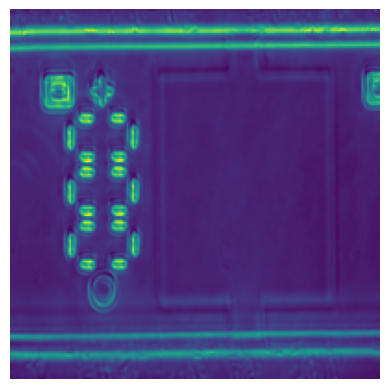

In [5]:
# Helper function to show image
def imshow(img):
    # Denormalize the image
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Turn off axis numbers
    plt.show()
(image, label)= full_dataset[0]
imshow(image)

In [6]:
# Perform the split
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_length, val_length, test_length])

# Initialize dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split


In [8]:
dataiter = iter(train_loader)
#dataiter = iter(test_loader)
images, labels = next(dataiter)

In [9]:
images[1]

tensor([[[2184, 2203, 2152,  ..., 2414, 2358, 2329],
         [2240, 2184, 2169,  ..., 2565, 2503, 2457],
         [2213, 2197, 2202,  ..., 2686, 2516, 2439],
         ...,
         [2018, 1879, 1815,  ..., 1733, 1749, 1693],
         [1855, 1745, 1790,  ..., 1682, 1728, 1748],
         [1742, 1629, 1778,  ..., 1638, 1618, 1717]]], dtype=torch.int32)

In [10]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

2678
574
574


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # 1 channel input for grayscale
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Fully connected layers
        self.fc1 = nn.Linear(147456, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # 1 output for regression
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = torch.flatten(x, 1)  # Flatten the tensor
        # print(x.shape)  # <-- Add this print statement
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation for the last layer in regression
        
        return x


# Create an instance of the model
model = RegressionCNN()
print(model)


RegressionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=147456, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [12]:
# import torch.nn as nn
# import torch.nn.functional as F

# class RegressionCNN(nn.Module):
#     def __init__(self, dropout: float = 0.4):
#         super(RegressionCNN, self).__init__()
        
#         self.features = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, padding=1),
#             nn.BatchNorm2d(16),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(16, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(2, 2),

#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
            
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#         )

#         # The fully connected part. Note: you'll need to adjust the input size of the first linear layer based on the output size from the features
#         self.regressor = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(160000, 500),  # Adjust SOME_DIM1 and SOME_DIM2 based on the output size from the features
#             nn.Dropout(dropout),
#             nn.InstanceNorm1d(500),
#             nn.ReLU(inplace=True),
#             nn.Linear(500, 1)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = self.regressor(x)
#         return x

# # Create an instance of the model
# model = RegressionCNN()
# print(model)


In [13]:
# Empty the cache
torch.cuda.empty_cache()

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [20]:

# Move model to the appropriate device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau

epochs = 10
steps = 0
print_every = 20
running_loss = 0
patience = 3
best_val_loss = None
epochs_no_improve = 0

# Initialize a scheduler for learning rate reduction
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=patience, verbose=True)

train_losses, validation_losses = [], []
model.to(device)

stop_training = False

for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1

        # Move inputs and label to the default device
        inputs, labels = inputs.to(device).to(device).float(), labels.to(device).to(device).float()

        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of the model and compute loss 
        outputs = model(inputs).squeeze(1)  # Removing extra dimension
        loss = criterion(outputs, labels)

        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            validation_loss = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device).to(device).float(), labels.to(device).to(device).float()
                    outputs = model(inputs).squeeze(1)  # Removing extra dimension
                    batch_loss = criterion(outputs, labels)
                    validation_loss += batch_loss.item()

            model.train()

            # Save the model if validation loss is below 100
            if validation_loss/len(val_loader) < 5:
                torch.save(model.state_dict(), "checkpoint.pth")
                print(f"Model saved with validation loss: {validation_loss/len(val_loader):.3f}")
                stop_training = True  # Set flag to True to break outer loop
                break
            
            train_losses.append(running_loss/print_every)
            validation_losses.append(validation_loss/len(val_loader))
            
            # Check if the validation loss is at a minimum
            if best_val_loss is None or validation_loss < best_val_loss:
                best_val_loss = validation_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                
            # Check for early stopping
            if epochs_no_improve == patience:
                print("Early stopping!")
                break

            print(f"Epoch: {epoch+1}/{epochs}.. ",
                  f"Training Loss: {running_loss/print_every:.3f}.. ",
                  f"Validation Loss: {validation_loss/len(val_loader):.3f}")

            running_loss = 0

    # If flag is set, break out of the outer loop
    if stop_training:
        break
            
    # Reduce learning rate if no improvement in validation loss
    scheduler.step(validation_loss)
            
    # Break outer loop if early stopping was triggered
    if epochs_no_improve == patience:
        break


Epoch: 1/10..  Training Loss: 138.481..  Validation Loss: 33.363
Epoch: 1/10..  Training Loss: 20.568..  Validation Loss: 9.505
Epoch: 1/10..  Training Loss: 10.039..  Validation Loss: 7.006
Epoch: 1/10..  Training Loss: 7.998..  Validation Loss: 7.311
Epoch: 1/10..  Training Loss: 6.946..  Validation Loss: 16.136
Early stopping!


In [17]:
# Set the model to evaluation mode
model.eval()

test_loss = 0.0

# Disabling gradient computation since we don't need gradients for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device).float(), labels.to(device).float()
        outputs = model(inputs).squeeze(1)  # Removing extra dimension
        batch_loss = criterion(outputs, labels)
        test_loss += batch_loss.item()

# Calculate average test loss
average_test_loss = test_loss / len(test_loader)

print(f"Test Loss: {average_test_loss:.3f}")


Test Loss: 6.867
